In [83]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from scipy.signal import savgol_filter


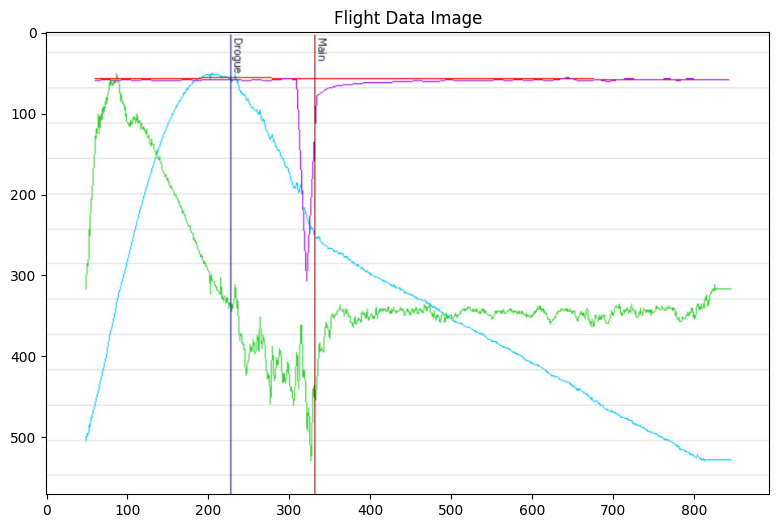

In [84]:
# Load the uploaded flight data image
image_path = "croped.jpg"
img = Image.open(image_path)

# Display the image for manual inspection and alignment
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.title("Flight Data Image")
plt.axis("on")
plt.show()

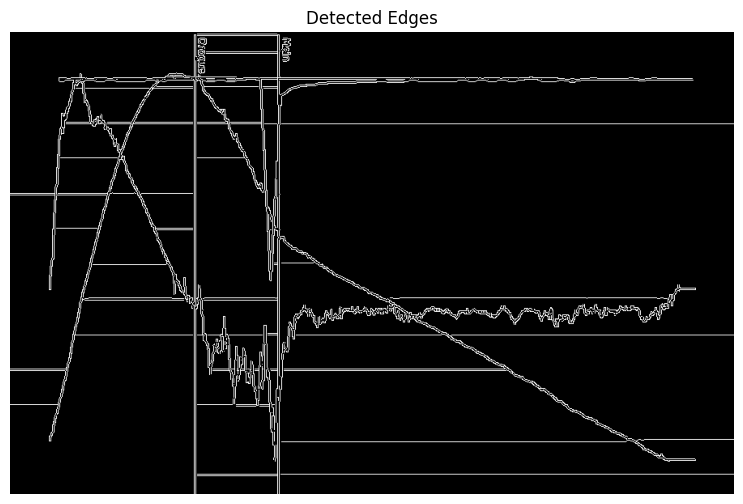

In [85]:
# Convert image to OpenCV format and grayscale
img_cv = np.array(img)
gray = cv2.cvtColor(img_cv, cv2.COLOR_RGB2GRAY)

# Apply edge detection
edges = cv2.Canny(gray, threshold1=50, threshold2=150)

# Display edges to help identify curves
plt.figure(figsize=(12, 6))
plt.imshow(edges, cmap='gray')
plt.title("Detected Edges")
plt.axis("off")
plt.show()

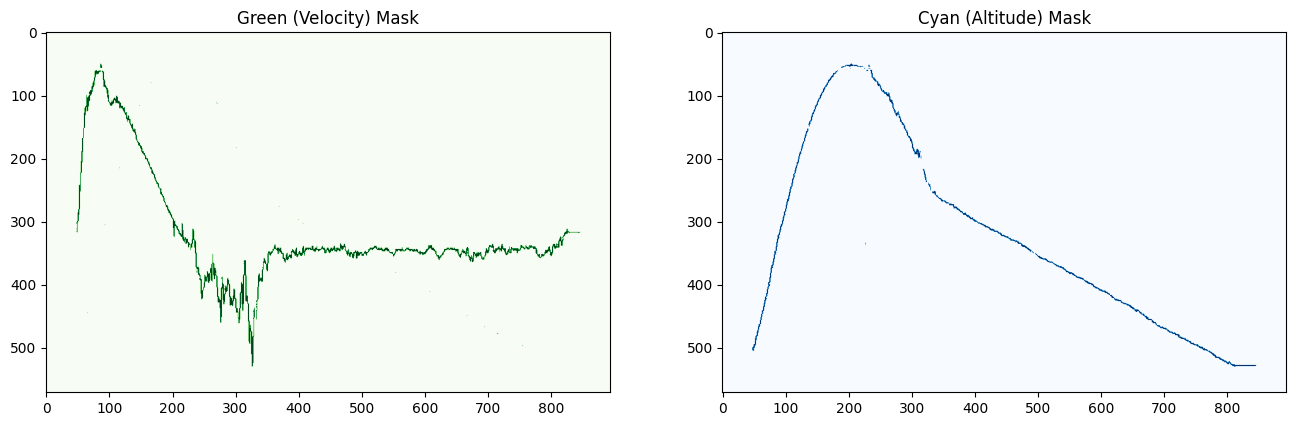

In [86]:
# Convert image to HSV to isolate colors
hsv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2HSV)

# Define color ranges to mask green (velocity) and cyan (altitude)
green_lower = np.array([40, 50, 50])
green_upper = np.array([90, 255, 255])

cyan_lower = np.array([80, 50, 50])
cyan_upper = np.array([100, 255, 255])

# Create masks for green and cyan
mask_green = cv2.inRange(hsv, green_lower, green_upper)
mask_cyan = cv2.inRange(hsv, cyan_lower, cyan_upper)

# Get non-zero pixel coordinates
green_coords = np.column_stack(np.where(mask_green > 0))
cyan_coords = np.column_stack(np.where(mask_cyan > 0))

# Display masked results
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].imshow(mask_green, cmap="Greens")
ax[0].set_title("Green (Velocity) Mask")
ax[1].imshow(mask_cyan, cmap="Blues")
ax[1].set_title("Cyan (Altitude) Mask")
plt.show()

In [87]:
# Función para convertir coordenadas de píxel a valores reales
def pixel_to_data(coords, x_pix_min, x_pix_max, x_val_min, x_val_max, 
                         y_pix_min, y_pix_max, y_val_min, y_val_max):
    x_pix = coords[:, 1]
    y_pix = coords[:, 0]
    x_val = ((x_pix - x_pix_min) / (x_pix_max - x_pix_min)) * (x_val_max - x_val_min) + x_val_min
    y_val = ((y_pix - y_pix_min) / (y_pix_max - y_pix_min)) * (y_val_min - y_val_max) + y_val_max
    return np.column_stack((x_val, y_val))

# Coordenadas de píxeles del área del gráfico (estimadas del gráfico original)
x_pix_min, x_pix_max = 50, 850   # eje X: tiempo
y_pix_min, y_pix_max = 30, 520   # eje Y

# Rango de valores del gráfico
t_min, t_max = 0, 65            # tiempo en segundos
alt_min, alt_max = -200, 2200   # altura en metros
vel_min, vel_max = -80, 100     # velocidad en m/s

# Convertir las coordenadas
altitude_data = pixel_to_data(cyan_coords, x_pix_min, x_pix_max, t_min, t_max,
                                            y_pix_min, y_pix_max, alt_min, alt_max)
velocity_data = pixel_to_data(green_coords, x_pix_min, x_pix_max, t_min, t_max,
                                            y_pix_min, y_pix_max, vel_min, vel_max)

Extraer los csv para procesar algunos datos a mano

In [88]:
df = pd.DataFrame({
    'Time (s)': altitude_data[:, 0],
    'Altitude (m)': altitude_data[:, 1]
})
df.to_csv('raw_altitude_flight_data.csv', index=False)

df = pd.DataFrame({
    'Time (s)': velocity_data[:, 0],
    'Velocity (m/s)': velocity_data[:, 1]
})
df.to_csv('raw_velocity_flight_data.csv', index=False)

## Process data

Los archivos tienen muchos datos inecesarios y si no se eliminan la aceleración no tiene sentido. Los elimine a mano con excel


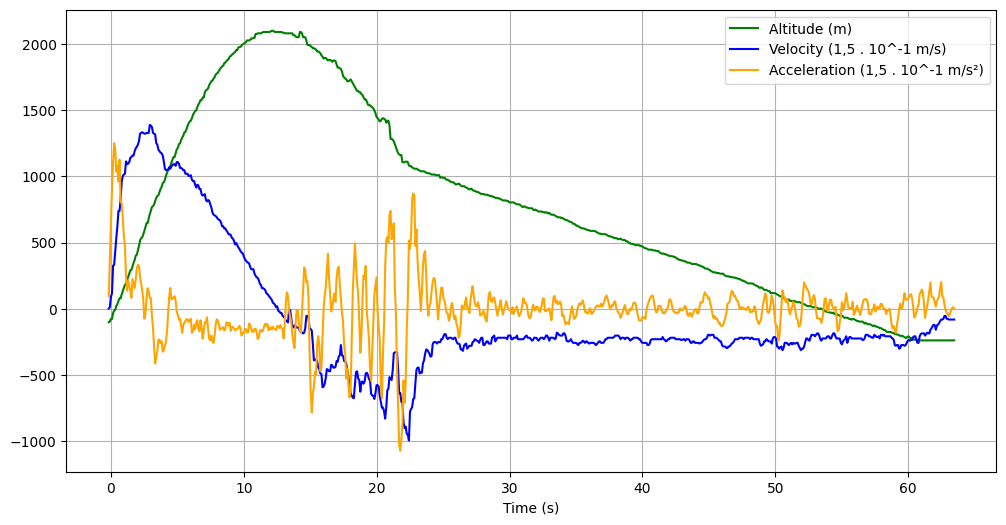

In [98]:
df_clean = pd.read_csv('processed_flight_data.csv')

plt.figure(figsize=(12, 6))
plt.plot(df_clean['Time (s)'], df_clean['Altitude (m)'], label='Altitude (m)', color='green')
plt.plot(df_clean['Time (s)'], df_clean['Velocity (m/s)']*15, label='Velocity (1,5 . 10^-1 m/s)', color='blue')
plt.plot(df_clean['Time (s)'], savgol_filter(df_clean['Acceleration (m/s²)'], window_length=11, polyorder=3)*15, label='Acceleration (1,5 . 10^-1 m/s²)', color='orange')
# plt.plot(df_clean['Time (s)'], df_clean['Acceleration (m/s²)']*10, label='Acceleration (10^-1 m/s)', color='orange')

plt.xlabel('Time (s)')
plt.grid(True)
plt.legend()
plt.show()

Para mejor aproximacion hay que suavizar la velocidad. Los datos hasta APOGEE tienen menos ruido y son los que me importa analizar así solo tomo ese rango de datos

In [89]:
df = pd.read_csv("apogee.csv")   

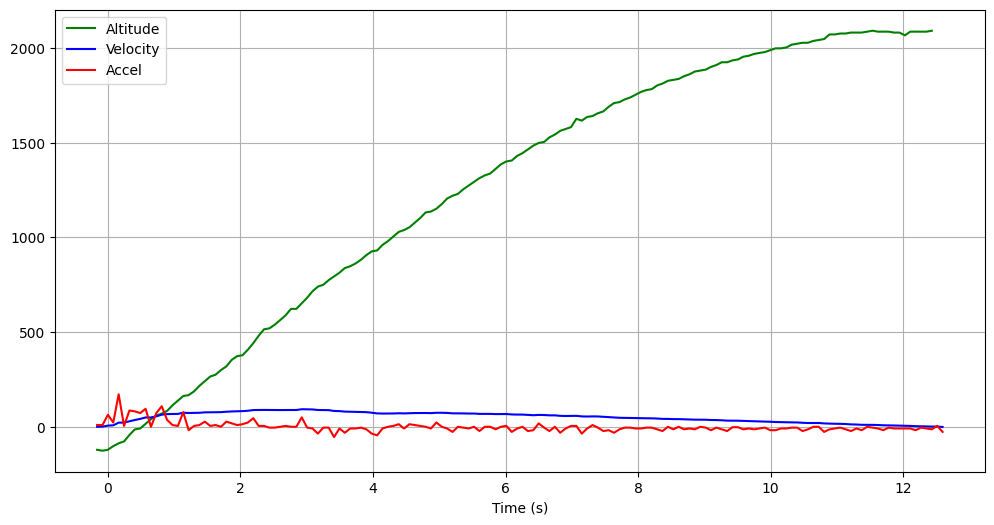

In [90]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['Time (s)'], df['Altitude (m)'], label='Altitude', color='green')
plt.plot(df['Time (s)'], df['Velocity (m/s)'], label='Velocity', color='blue')
plt.plot(df['Time (s)'], df['Acceleration (m/s²)'], label='Accel', color='red')

plt.xlabel('Time (s)')
plt.grid(True)
plt.legend()
plt.show()


In [91]:
altitude = savgol_filter(df['Altitude (m)'], window_length=11, polyorder=3)
velocity = savgol_filter(df['Velocity (m/s)'], window_length=11, polyorder=3)
smooth_acceleration = np.gradient(velocity, 0.08125)
acceleration = np.gradient(df['Velocity (m/s)'], 0.08125)

In [92]:
import math

In [93]:
print("float acceleration [] = [")
num = 0
for a in acceleration:
    if not math.isnan(a):
        num += 1
        print(f"{a},")
print("];")        
num

float acceleration [] = [
9.042386185243544,
36.16954474097329,
42.951334379905674,
97.20565149136567,
88.16326530612226,
45.21193092621661,
83.64207221350094,
76.8602825745686,
83.64207221350091,
47.47252747252739,
36.16954474097353,
90.42386185243322,
72.33908948194644,
22.60596546310834,
6.781789638932353,
40.69073783359508,
29.387755102040604,
-6.781789638932353,
6.781789638932878,
18.084772370486128,
15.824175824176073,
6.781789638932965,
4.521193092621511,
13.56357927786462,
22.60596546310834,
13.56357927786523,
11.302982731553776,
18.084772370486743,
33.90894819466281,
24.866562009419095,
4.521193092621511,
0.0,
-4.521193092621511,
-2.2605965463107554,
2.2605965463107554,
2.2605965463107554,
0.0,
24.866562009419095,
22.60596546310834,
-6.781789638932353,
-22.60596546310834,
-20.345368916797497,
-4.521193092621511,
-29.387755102040604,
-31.648351648352058,
-20.345368916798197,
-20.345368916797497,
-9.042386185243021,
-6.781789638932353,
-9.042386185243108,
-24.866562009419006,
-4

157

In [94]:
calculated_vel = [0.367347, 2.204082, 5.418367, 11.112245, 18.642857, 24.061224, 29.295918, 35.816326, 42.336735, 47.663265, 51.061226, 56.204082, 62.816326, 66.673470, 67.867348, 69.795921, 72.642860, 73.561226, 73.561226, 74.571426, 75.948975, 76.867340, 77.326523, 78.061218, 79.530609, 81.000000, 82.010201, 83.204079, 85.316322, 87.704079, 88.897957, 88.897957, 88.714287, 88.438774, 88.438774, 88.622444, 88.622444, 89.632645, 91.561218, 92.204079, 91.010201, 89.265305, 88.255104, 86.877556, 84.397964, 82.285721, 80.632660, 79.438782, 78.795921, 78.153061, 76.775513, 74.112244, 71.357140, 70.071426, 69.979591, 70.438774, 70.897957, 71.081627, 71.632645, 72.367340, 72.734688, 72.642853, 72.734688, 73.469383, 73.744896, 72.826530, 71.540817, 70.897957, 70.530609, 70.071426, 69.428566, 68.510201, 68.510201, 68.234688, 67.683670, 67.500000, 67.132652, 65.938774, 65.020409, 64.377548, 63.091835, 63.091835, 63.367344, 63.091835, 62.081631, 60.979591, 59.510204, 58.591835, 58.683670, 58.224487, 56.663261, 56.663261, 56.755096, 56.295914, 54.918362, 53.081627, 51.153057, 49.867344, 49.316322, 48.857140, 48.214283, 47.571426, 47.112244, 46.561222, 45.459183, 44.265305, 43.530609, 42.979588, 42.428566, 41.693871, 40.775505, 40.040810, 39.673462, 39.122440, 38.204075, 37.377544, 36.275505, 35.035709, 34.438770, 34.025505, 33.244892, 32.326527, 31.408159, 30.673466, 29.938772, 28.744894, 27.459179, 26.540812, 25.897955, 25.438772, 24.704079, 23.418364, 22.408159, 22.408159, 21.857140, 20.479588, 19.193872, 18.459179, 17.816322, 16.714281, 15.336730, 14.142853, 13.224485, 12.765302, 12.397955, 11.571424, 10.561220, 9.826527, 9.183669, 8.448976, 7.714282, 6.795914, 5.785710, 5.051016, 4.316322, 3.673465, 3.030608]
len(calculated_vel)

157

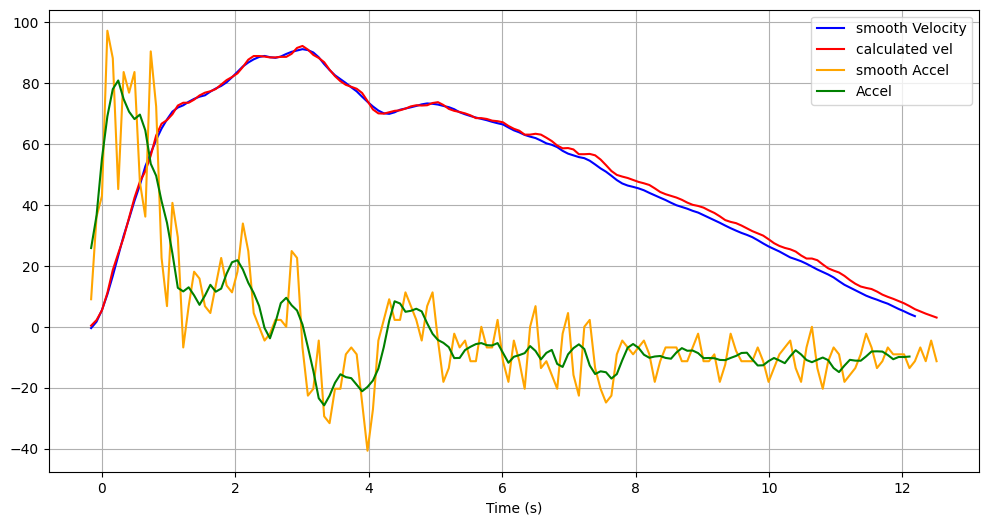

In [95]:
plt.figure(figsize=(12, 6))
# plt.plot(df['Time (s)'], altitude, label='Altitude', color='green')
plt.plot(df['Time (s)'][0:157], velocity[0:157], label='smooth Velocity', color='blue')
plt.plot(df['Time (s)'][0:157], calculated_vel, label='calculated vel', color='red')
plt.plot(df['Time (s)'][0:157], acceleration[0:157], label='smooth Accel', color='orange')
plt.plot(df['Time (s)'][0:157], smooth_acceleration[0:157], label='Accel', color='green')

plt.xlabel('Time (s)')
plt.grid(True)
plt.legend()
plt.show()


## Data for testbench

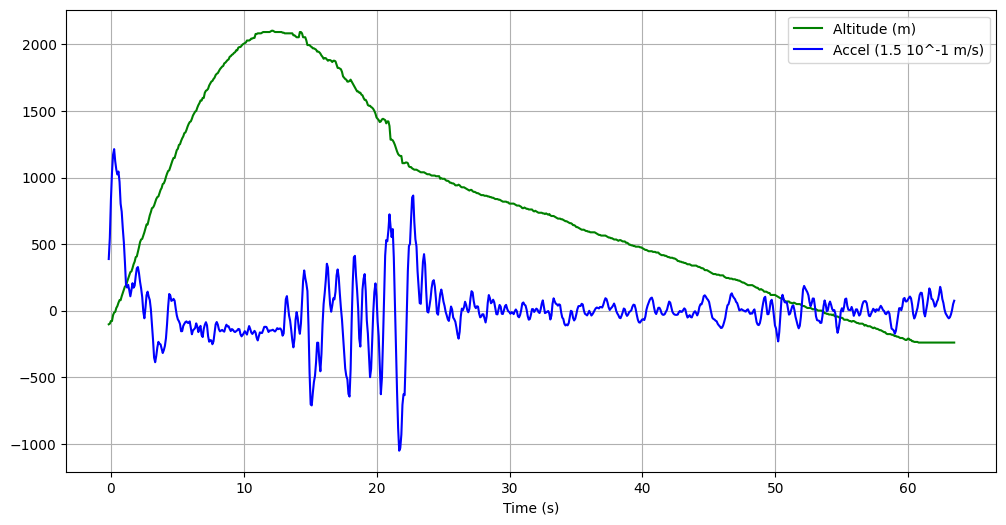

In [105]:
altitude_tb = df_clean['Altitude (m)']
velocity_tb = savgol_filter(df_clean['Velocity (m/s)'], window_length=11, polyorder=3)
acceleration_tb = np.gradient(velocity, 0.08125)

plt.figure(figsize=(12, 6))
plt.plot(df_clean['Time (s)'], altitude_tb, label='Altitude (m)', color='green')
plt.plot(df_clean['Time (s)'], acceleration_tb*15, label='Accel (1.5 10^-1 m/s)', color='blue')

plt.xlabel('Time (s)')
plt.grid(True)
plt.legend()
plt.show()

### Create C++ testbench

In [106]:
print("int16_t altitude_tb [] = {")
for alt in altitude_tb:
    if not math.isnan(alt):
        print(f"{int(alt)},")
print("};\n")

print("float acceleration_tb [] = {")
for acc in acceleration_tb:
    if not math.isnan(acc):
        print(f"{acc},")
print("};")


int16_t altitude_tb [] = {
-102,
-97,
-77,
-77,
-33,
-13,
-8,
20,
35,
59,
79,
79,
108,
133,
157,
182,
186,
216,
240,
265,
289,
294,
319,
348,
368,
402,
407,
441,
475,
515,
534,
539,
564,
588,
617,
647,
647,
681,
715,
740,
769,
774,
789,
813,
838,
853,
857,
882,
906,
921,
951,
955,
975,
1004,
1029,
1048,
1053,
1078,
1102,
1127,
1146,
1146,
1176,
1205,
1215,
1244,
1249,
1274,
1293,
1308,
1333,
1337,
1357,
1382,
1401,
1416,
1421,
1440,
1465,
1480,
1494,
1499,
1524,
1543,
1558,
1577,
1577,
1597,
1597,
1636,
1651,
1656,
1666,
1690,
1705,
1720,
1724,
1739,
1749,
1768,
1778,
1783,
1798,
1813,
1822,
1832,
1837,
1857,
1862,
1871,
1881,
1886,
1906,
1911,
1920,
1925,
1935,
1940,
1955,
1955,
1974,
1979,
1979,
1989,
1999,
2004,
2008,
2013,
2028,
2028,
2028,
2033,
2043,
2043,
2048,
2048,
2077,
2077,
2082,
2082,
2082,
2082,
2087,
2092,
2092,
2092,
2092,
2092,
2092,
2092,
2097,
2102,
2102,
2097,
2092,
2092,
2092,
2092,
2092,
2092,
2092,
2087,
2087,
2082,
2082,
2082,
2082,
2082,
2082,
2082,
2082,
2067,